In [37]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import geopandas as gpd
import rasterio

from shapely.geometry import Point
from rasterio import features
from rasterio.plot import show, show_hist


In [28]:
target_year = '2015'

# directory containing demeter input and output directories
demeter_dir = '/Users/d3y010/projects/msd_live/gcam_demeter_demo/demeter_data'

# directory containing Demeter's GCAM projected land allocation file
projected_dir = os.path.join(demeter_dir, 'inputs', 'projected')

# directory containing Demeter's outputs
demeter_output_dir = os.path.join(demeter_dir, 'outputs', 'example_2020-11-03_21h37m54s', 'spatial_landcover_tabular')

# demeter output file for the target year
demeter_lc_file = os.path.join(demeter_output_dir, f"landcover_{target_year}_timestep.csv")

# Demeter's GCAM projected land allocation file
gcam_projected_file = os.path.join(projected_dir, 'gcam_ref_scenario_reg32_basin235_v5p1p3.csv')

# a Pandas data frame of GCAM's projected land allocation data
gcam_df = pd.read_csv(gcam_projected_file)

# Demeter's output land allocation data
demeter_df = pd.read_csv(demeter_lc_file)

rast = '/Users/d3y010/Desktop/rast.tif'
dem_template = '/Users/d3y010/Desktop/demeter_conus_template.tif'


In [5]:
demeter_df.head()

,latitude,longitude,basin_id,region_id,water,forest,shrub,grass,urban,snow,sparse,crops
0,-55.7916,-67.4584,169,26,35.0805,12.68490,0.0,0.290043,0.0,0.0,0.0,0.0
1,-55.7916,-67.3750,169,26,23.3069,24.45850,0.0,0.290043,0.0,0.0,0.0,0.0
2,-55.7916,-67.2917,169,26,17.6604,29.98490,0.0,0.410181,0.0,0.0,0.0,0.0
3,-55.7916,-67.2084,169,26,30.5152,17.54020,0.0,0.000000,0.0,0.0,0.0,0.0
4,-55.7916,-67.1250,169,26,39.6457,8.14879,0.0,0.260913,0.0,0.0,0.0,0.0


In [11]:
# extract the USA
demeter_usa_df = demeter_df.loc[demeter_df['region_id'] == 1].copy()

In [12]:
# create geometry column from coordinate fields
geometry = [Point(xy) for xy in zip(demeter_usa_df['longitude'], demeter_usa_df['latitude'])]

# coordinate reference system for WGS84
crs = 'epsg:4326'

gdf = gpd.GeoDataFrame(demeter_usa_df, crs=crs, geometry=geometry)

In [78]:
r = rasterio.open(dem_template)
meta = r.meta.copy()
meta.update(compress='lzw')

with rasterio.open(rast, 'w+', **meta) as out:
    
    out_arr = out.read(1)
    
    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf['forest']))

    burned = features.rasterize(shapes=shapes, fill=meta['nodata'], out=out_arr, transform=out.transform)
    out.write_band(1, burned)
    


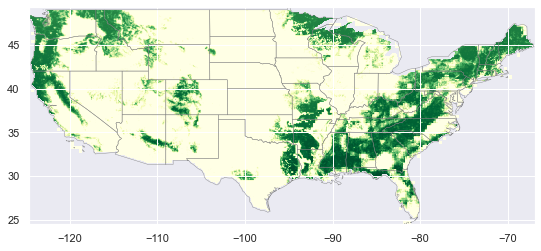

In [79]:
from matplotlib import pyplot as plt

bdf = gpd.read_file('/Users/d3y010/projects/gis/natural_earth/ne_50m_conus.shp')

with rasterio.open(rast) as src:
    fig, ax = plt.subplots(1, figsize=(10, 4))
    
    bdf.geometry.boundary.plot(ax=ax, color='grey', lw=0.4)
    show(src, cmap='YlGn', ax=ax)


In [24]:
gxf.basin_id.unique()

array([217, 222, 220, 223, 218, 228, 227, 233, 232, 229,  23,  27, 231,
       226, 225, 219, 221,  96, 224, 230])

<AxesSubplot:>

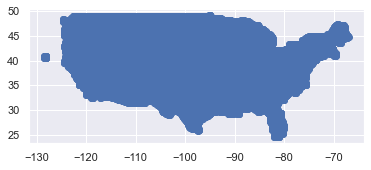

In [25]:
conus_basins = [217, 222, 220, 223, 218, 228, 227, 233, 232, 229, 23, 27, 
                231, 226, 225, 219, 221,  96, 224, 230]

conus_gdf = gdf.loc[gdf['basin_id'].isin(conus_basins)]
conus_gdf.geometry.plot()

In [80]:
bdf.head()

,name,geometry
0,Alabama,"MULTIPOLYGON (((-87.48951 30.37768, -87.51325 ..."
1,Arkansas,"POLYGON ((-89.70477 36.00157, -89.70932 35.983..."
2,Arizona,"POLYGON ((-109.04781 31.32788, -109.27477 31.3..."
3,California,"MULTIPOLYGON (((-114.61054 34.99112, -114.6109..."
4,Colorado,"POLYGON ((-109.04667 37.00085, -109.04665 37.2..."
